# Final Claim Cost Modeling – Regression Ensemble (XGBoost + GLM)

This notebook develops and evaluates regression models to forecast the final cost of insurance claims (sum of actual payouts and reserves). The goal is to improve prediction accuracy using both machine learning and statistical modeling approaches and to analyze the business impact of model improvements.

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import TweedieRegressor, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import shap

plt.style.use('dark_background')

In [2]:
# Load the dataset
df = pd.read_csv("../data/merged_data.csv")

## Data Preparation

- Features include policy characteristics, FNOL (First Notification of Loss) data, regional indicators, claim delay metrics, and engineered log-transformed features.
- The target variable is `final_loss`, log-transformed as `log(final_loss)` to reduce the impact of extreme values.

In [ ]:
# New feature: logarithm of minimum vehicle weight
df["car_weight_min_log"] = np.log1p(df["car_weight_min"])

# Nonlinear feature: notification delay squared
df["notification_delay_days_squared"] = df["notification_delay_days"] ** 2

# Indicator: whether payment has been made
df["has_payout"] = (df["actual_sum_of_payouts"] > 0).astype(int)

# Sign: time from FNOL to first payment (if dates are specified)
df["claim_reported"] = pd.to_datetime(df["claim_reported"], errors='coerce')
df["first_payout_date"] = pd.to_datetime(df["first_payout_date"], errors='coerce')
df["fnol_to_first_payout_days"] = (df["first_payout_date"] - df["claim_reported"]).dt.days
df["fnol_to_first_payout_days"] = df["fnol_to_first_payout_days"].fillna(-1)

# Target encoding a car brand
car_make_mean = df.groupby("car_make")["final_loss"].mean()
df["car_make_encoded"] = df["car_make"].map(car_make_mean)

# Frequency of losses by region
region_mean = df.groupby("postalcode_group")["final_loss"].mean()
df["region_claim_rate"] = df["postalcode_group"].map(region_mean)

# 
new_features = [
    "car_weight_min_log",
    "notification_delay_days_squared",
    "has_payout",
    "fnol_to_first_payout_days",
    "car_make_encoded",
    "region_claim_rate"
]

df[new_features].describe()

,car_weight_min_log,notification_delay_days_squared,has_payout,fnol_to_first_payout_days,car_make_encoded,region_claim_rate
count,1791.000000,1791.000000,1791.000000,1791.000000,1.791000e+03,1791.000000
mean,7.165877,505.993300,0.546622,22.787828,7.738862e+05,773886.208142
std,0.207178,2263.395525,0.497961,32.307819,1.359284e+05,75898.442807
min,6.486161,0.000000,0.000000,-1.000000,0.000000e+00,615388.442857
25%,7.017954,9.000000,0.000000,-1.000000,6.743204e+05,704277.572414
50%,7.169350,36.000000,1.000000,10.000000,7.512260e+05,808575.305804
75%,7.310550,169.000000,1.000000,37.000000,8.421928e+05,837794.784394
max,7.899524,28224.000000,1.000000,251.000000,2.200000e+06,875066.072993


## Models Compared

Three models are compared:
- **XGBoost** (gradient boosting decision trees)
- **GLM Tweedie** (generalized linear model with a Tweedie distribution for positive, skewed targets)
- **Stacked Ensemble** (combination of XGBoost and GLM with Ridge Regression as meta-model)

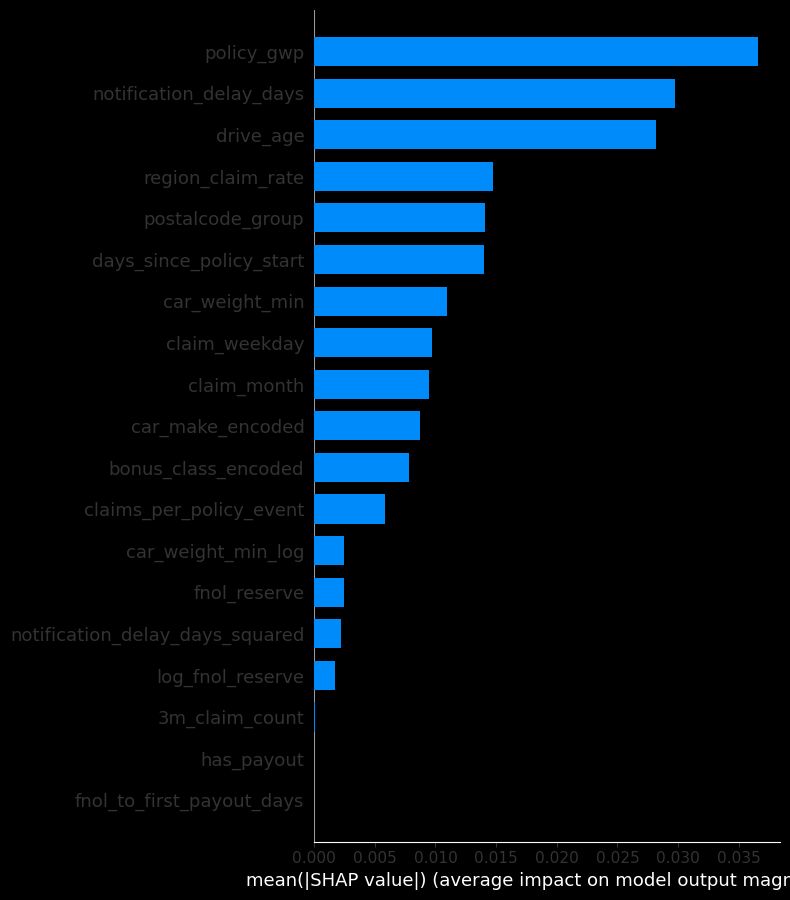

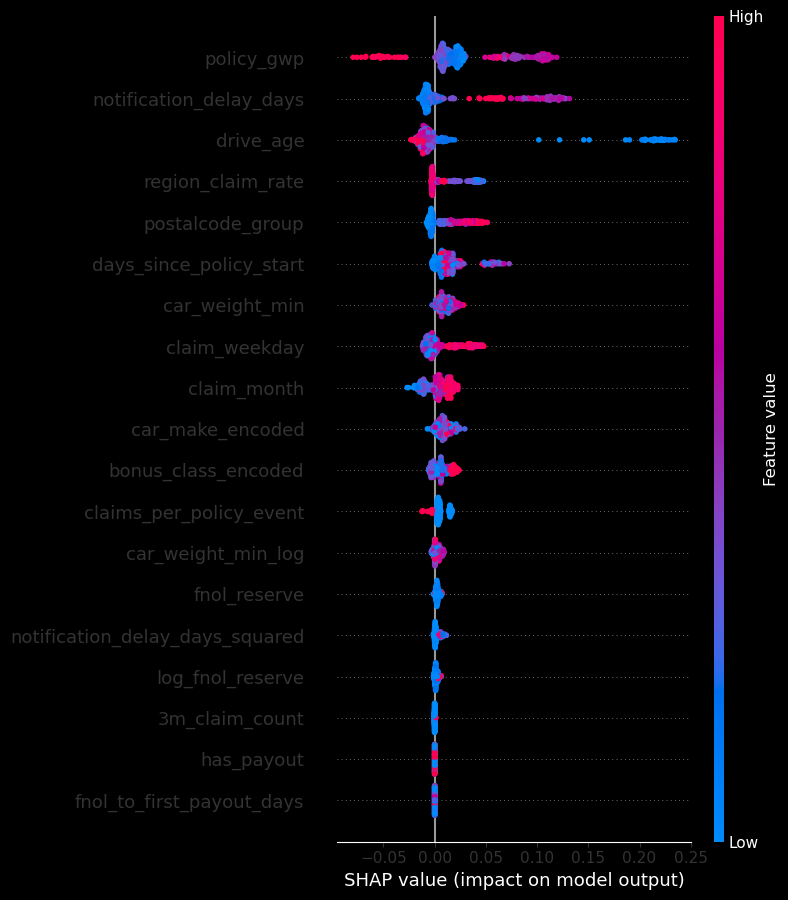

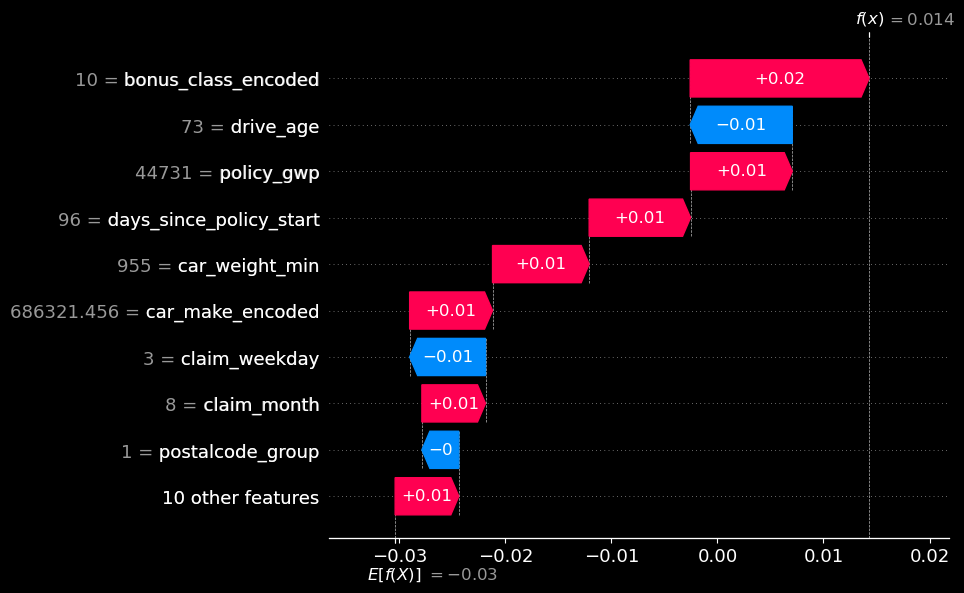

,Model,MAE,RMSE,R2
0,XGBoost (log target),648776.455389,9.518462e+05,-0.867678
1,GLM Tweedie (log target),529242.145632,1.161166e+06,-1.779439


In [ ]:
features = [
    "policy_gwp", "drive_age", "car_weight_min", "car_weight_min_log", "bonus_class_encoded",
    "postalcode_group", "notification_delay_days", "notification_delay_days_squared",
    "days_since_policy_start", "fnol_reserve", "log_fnol_reserve", "claims_per_policy_event",
    "claim_month", "claim_weekday", "3m_claim_count", "has_payout",
    "fnol_to_first_payout_days", "car_make_encoded", "region_claim_rate"
]

X = df[features]
y_log = np.log1p(df["final_loss"])
sample_weight = 1 / (1 + df["final_loss"])

# Train/Test Split
X_train, X_test, y_train_log, y_test_log, w_train, w_test = train_test_split(
    X, y_log, sample_weight, test_size=0.2, random_state=42
)

# XGBoost + RandomizedSearchCV
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist, n_iter=20,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
random_search.fit(X_train, y_train_log, sample_weight=w_train)
best_xgb = random_search.best_estimator_

# Cross-validation
cv_scores = cross_val_score(best_xgb, X, y_log, scoring='neg_mean_squared_error', cv=5)
cv_rmse = np.sqrt(-cv_scores)

# GLM Tweedie
glm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("glm", TweedieRegressor(power=1.5, alpha=0.1))
])
glm_pipeline.fit(X_train, y_train_log)
glm_preds_log = glm_pipeline.predict(X_test)

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

shap.summary_plot(shap_values, X_test)

# Individual explanation for observation #42 (example)
shap.plots.waterfall(shap.Explanation(values=shap_values[42],
                                      base_values=explainer.expected_value,
                                      data=X_test.iloc[42],
                                      feature_names=X_test.columns.tolist()))

# Inverse log conversion
xgb_preds = np.expm1(best_xgb.predict(X_test))
glm_preds = np.expm1(glm_preds_log)
y_test = np.expm1(y_test_log)

# Estimating models
def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    }

results = [
    evaluate_model("XGBoost (log target)", y_test, xgb_preds),
    evaluate_model("GLM Tweedie (log target)", y_test, glm_preds)
]

results_df = pd.DataFrame(results)
results_df

In [ ]:
errors_df = X_test.copy()

errors_df["true_final_loss"] = y_test
errors_df["xgb_pred"] = xgb_preds
errors_df["glm_pred"] = glm_preds

errors_df["xgb_abs_error"] = np.abs(errors_df["true_final_loss"] - errors_df["xgb_pred"])
errors_df["glm_abs_error"] = np.abs(errors_df["true_final_loss"] - errors_df["glm_pred"])

errors_df["xgb_error_ratio"] = errors_df["xgb_abs_error"] / (errors_df["true_final_loss"] + 1)
errors_df["glm_error_ratio"] = errors_df["glm_abs_error"] / (errors_df["true_final_loss"] + 1)

top_10_errors = errors_df.sort_values(by="xgb_abs_error", ascending=False).head(10)

print("Top 10 XGBoost prediction errors (with GLM comparison):")
top_10_errors[[
    "true_final_loss", "xgb_pred", "glm_pred",
    "xgb_abs_error", "glm_abs_error",
    "xgb_error_ratio", "glm_error_ratio"
]]

Top 10 XGBoost prediction errors (with GLM comparison):


,true_final_loss,xgb_pred,glm_pred,xgb_abs_error,glm_abs_error,xgb_error_ratio,glm_error_ratio
1247,4433000.0,0.464464,2.334125e+05,4.433000e+06,4.199587e+06,1.0,0.947346
1612,3849000.0,-0.002081,7.279155e+05,3.849000e+06,3.121085e+06,1.0,0.810882
71,3471337.0,0.195934,3.189957e+05,3.471337e+06,3.152341e+06,1.0,0.908106
1010,3351347.0,0.109095,8.324754e+05,3.351347e+06,2.518872e+06,1.0,0.751600
1732,3167134.0,0.121957,4.633513e+05,3.167134e+06,2.703783e+06,1.0,0.853700
1483,3014000.0,0.072542,2.989774e+05,3.014000e+06,2.715023e+06,1.0,0.900803
1110,3000000.0,0.210831,6.406909e+05,3.000000e+06,2.359309e+06,1.0,0.786436
32,2861361.0,0.113141,7.629634e+05,2.861361e+06,2.098398e+06,1.0,0.733356
637,2854792.0,0.400124,1.562243e+07,2.854792e+06,1.276764e+07,1.0,4.472351
352,2830689.0,0.102565,5.110213e+05,2.830689e+06,2.319668e+06,1.0,0.819471


,Model,MAE,RMSE,R2
0,XGBoost (fast),648776.532279,9.518463e+05,-0.867678
1,GLM Tweedie,529242.145632,1.161166e+06,-1.779439
2,Stacked Ensemble,415654.699468,7.021753e+05,-0.016388


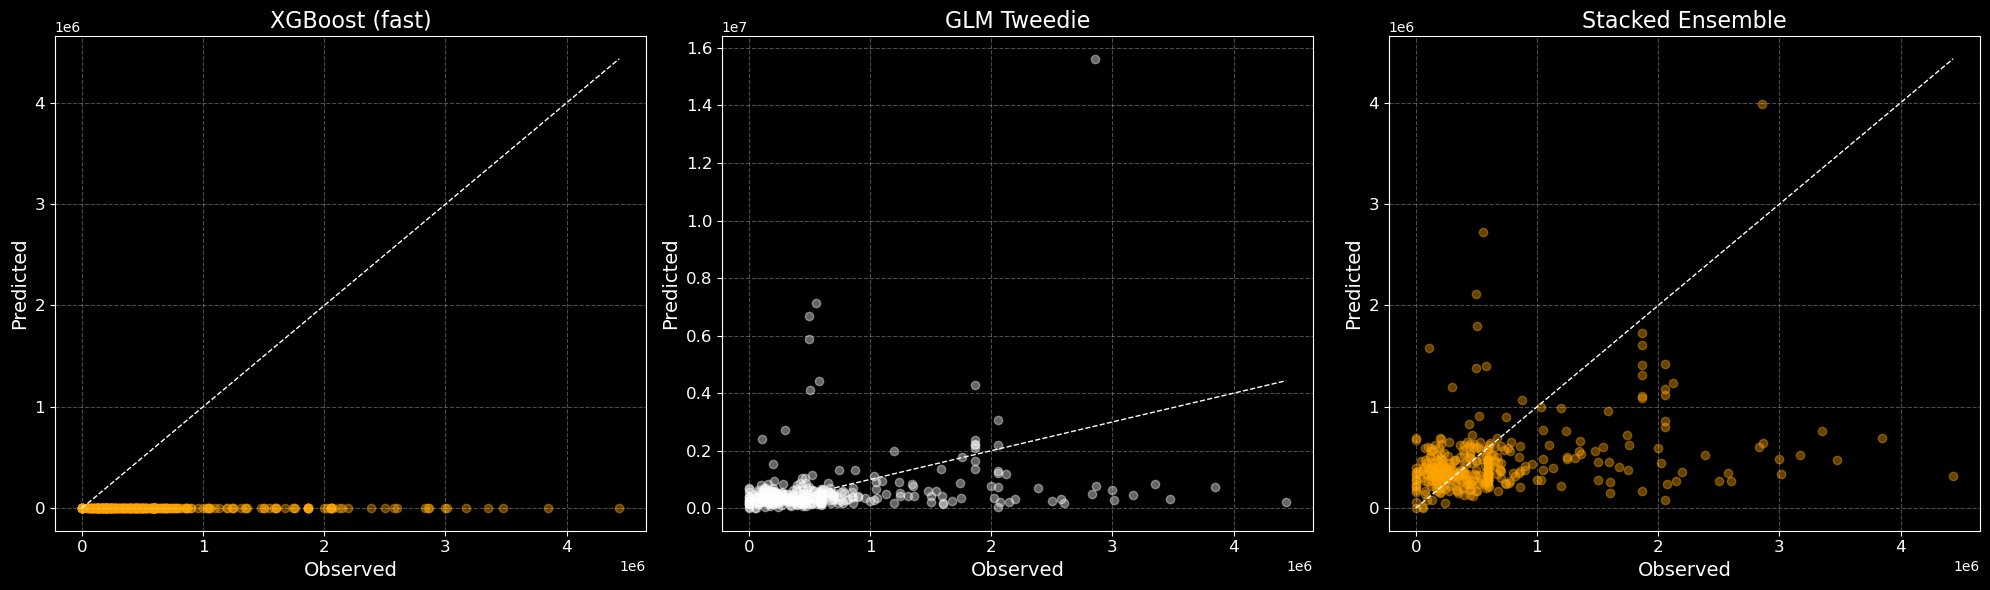

In [ ]:
# XGBoost (ускоренный)
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train, y_train_log, sample_weight=w_train)
xgb_preds = np.expm1(xgb_model.predict(X_test))

# GLM Tweedie
glm_pipeline = make_pipeline(
    StandardScaler(),
    TweedieRegressor(power=1.5, alpha=0.1)
)
glm_pipeline.fit(X_train, y_train_log)
glm_preds = np.expm1(glm_pipeline.predict(X_test))

# Ensemble (stacked)
stacking_model = StackingRegressor(
    estimators=[("xgb", xgb_model), ("glm", glm_pipeline)],
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)
stacking_model.fit(X_train, y_train_log)
stacked_preds = np.expm1(stacking_model.predict(X_test))
y_test = np.expm1(y_test_log)


def evaluate_model(name, y_true, y_pred):
    return {
        "Model": name,
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "R2": r2_score(y_true, y_pred)
    }

results = [
    evaluate_model("XGBoost (fast)", y_test, xgb_preds),
    evaluate_model("GLM Tweedie", y_test, glm_preds),
    evaluate_model("Stacked Ensemble", y_test, stacked_preds)
]
results_df = pd.DataFrame(results)
display(results_df)

def plot_scatter(ax, y_true, y_pred, title, color):
    ax.scatter(y_true, y_pred, alpha=0.4, color=color)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'w--', lw=1)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Observed", fontsize=14)
    ax.set_ylabel("Predicted", fontsize=14)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='both', labelsize=12)

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

plot_scatter(axs[0], y_test, xgb_preds, "XGBoost (fast)", color='orange')
plot_scatter(axs[1], y_test, glm_preds, "GLM Tweedie", color='white')
plot_scatter(axs[2], y_test, stacked_preds, "Stacked Ensemble", color='orange')

plt.tight_layout()
plt.show()


## Evaluation Metrics

| Model              | MAE (Mean Abs. Error)  | RMSE (Root Mean Sq. Error)  | R² (Explained Variance)  |
|--------------------|------------------------|-----------------------------|--------------------------|
| XGBoost (fast)     | 648,776                | 951,846                     | -0.87                    |
| GLM Tweedie        | 529,242                | 1,161,166                   | -1.77                    |
| Stacked Ensemble   | **415,654**            | **702,175**                 | **-0.02**                |

### Insight:
Although the R² remains slightly negative, the ensemble model significantly reduces both MAE and RMSE compared to single models. This indicates a better average performance and more stable behavior on high-cost claims.

## Conclusions

- The ensemble approach produces significantly lower prediction errors.
- Combining GLM Tweedie (statistical robustness) and XGBoost (nonlinear flexibility) yields a stronger, more balanced model.
- For operational use in reserving and pricing, the ensemble model offers better overall consistency.
- Future improvements may include segment-level tuning, quantile regression for risk layering, and inclusion of prior claim history over longer time horizons.
